In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import kstest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import max_error

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/vehicle-claim-fraud-detection/fraud_oracle.csv


**Introduction**

With this project I'll be performing exploratory data analysis and machine learning on three years of vehicle accident claim data for a vehicle insurance company. The goal of this analysis is to create an algorithm for detecting fraud in future vehicle accident claims.

Detecting fraud is notoriously difficult, since it represents such a small percent of cases, and it is specifically meant to go undetected. Our first goal is to determine which variables are most correlated with vehicle claim fraud, and use that as a baseline for building our machine learning algorithm.

**About This Data**

This data was provided by Shivam Bansal, from a public domain source. It is a collection of insurance claims. There are approximately 14.5 thousand subjects, 923 of which are marked as fraudulent. Before we dive into analysis, we need to perform some basic data cleaning steps, and prepare the data for analysis.

**Step 1: Data Cleaning and Prep**

The first step is to view a breakdown of the variables. This dataset has 33 variables, made up of 24 'object' variables and 9 'integer' variables. In cleaning this data, we need to ensure that there are no null-values or duplicates, and remove needless variables from the equation.

In [2]:
data = pd.read_csv('../input/vehicle-claim-fraud-detection/fraud_oracle.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [3]:
#removing duplicates and unnecessary variables
data.drop_duplicates()
data.drop(['PolicyNumber','RepNumber'],inplace=True,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

Next, we need to create separate datasets for fraud and no-fraud, so that we can more easily measure the correlation between other variables and fraud. Then we'll add the sums together, to ensure we didn't lose any subjects.

After that, we'll make a bar chart to visualize how many fraudulent subjects there are as opposed to non-fraudulent ones. For the FraudFound_P column, 0 means fraud was not found, and 1 means fraud was found.

# of non-fraud claims
14497
# of fraud claims
923
total # of claims


[Text(0.5, 1.0, 'No Fraud vs Fraud totals')]

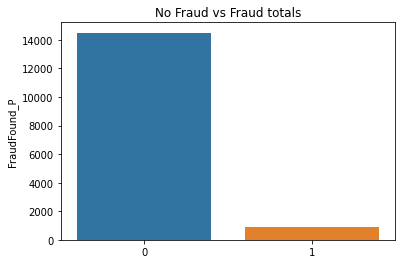

In [4]:
#creating separate datasets for fraud and no fraud
fraud_data = data[data.FraudFound_P==1]
nofraud_data = data[data.FraudFound_P==0]
#checking my work
print('# of non-fraud claims')
print(len(nofraud_data))
print('# of fraud claims')
print(len(fraud_data))
print('total # of claims')
len(fraud_data+nofraud_data)
sns.barplot(x=data['FraudFound_P'].value_counts().index,y=data['FraudFound_P'].value_counts()).set(title='No Fraud vs Fraud totals')

**Step 2: Exploratory Data Analysis**

Determining the correlation between variables is relatively simple, but it's not the whole picture. We'll use the corr() function as a baseline, then go a little deeper in our analysis to create some visualizations.

The first step is to create a list of all the variables we'd like to explore. Next, the corr() function will tell us what should be investigated more closely.

In [5]:
attributes=['Month','WeekOfMonth','DayOfWeek','Make','AccidentArea','DayOfWeekClaimed','MonthClaimed','WeekOfMonthClaimed','Sex','MaritalStatus','Age','Fault','PolicyType','VehicleCategory','VehiclePrice','Deductible','DriverRating','Days_Policy_Accident','Days_Policy_Claim','PastNumberOfClaims','AgeOfVehicle','AgeOfPolicyHolder','PoliceReportFiled','WitnessPresent','AgentType','NumberOfSuppliments','AddressChange_Claim','NumberOfCars','Year','BasePolicy']
data.corr()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,Deductible,DriverRating,Year
WeekOfMonth,1.000000,0.275400,-0.004810,-0.011861,-0.003993,-0.016817,-0.003906
WeekOfMonthClaimed,0.275400,1.000000,0.001859,-0.005761,0.005457,-0.000048,0.012175
Age,-0.004810,0.001859,1.000000,-0.029741,0.069420,0.001668,0.025197
FraudFound_P,-0.011861,-0.005761,-0.029741,1.000000,0.017348,0.007266,-0.024760
Deductible,-0.003993,0.005457,0.069420,0.017348,1.000000,0.003886,-0.001170
DriverRating,-0.016817,-0.000048,0.001668,0.007266,0.003886,1.000000,-0.013890
Year,-0.003906,0.012175,0.025197,-0.024760,-0.001170,-0.013890,1.000000


The corr() function returns the pairwise correlation of all columns in the dataframe, but we can create a function to find ONLY a variable's correlation with the FraudFound_P variable. In order to do that, we first need to transform all the strings to integers.

In [6]:
#transforming string to integer data
def transform(column):
    label=LabelEncoder().fit_transform(data[column])
    data.drop(column,axis=1,inplace=True)
    data[column]=label
def multi_transform(list):
    mt_list=[]
    for x in list:
        if x not in mt_list:
            transform(x)
multi_transform(attributes)

#calculating the correlation between each variable and fraud
def multi_corr(column):
    corr_list=[]
    for x in column:
        if x not in corr_list:
            c=data['FraudFound_P'].corr(data[x],method='pearson',min_periods=1)
            print(x)
            print(round(c,2))
print('Correlation scores by variable:')
multi_corr(attributes)

Correlation scores by variable:
Month
-0.01
WeekOfMonth
-0.01
DayOfWeek
-0.02
Make
-0.02
AccidentArea
-0.03
DayOfWeekClaimed
-0.0
MonthClaimed
-0.01
WeekOfMonthClaimed
-0.01
Sex
0.03
MaritalStatus
0.0
Age
-0.03
Fault
-0.13
PolicyType
-0.06
VehicleCategory
-0.1
VehiclePrice
0.06
Deductible
0.03
DriverRating
0.01
Days_Policy_Accident
0.01
Days_Policy_Claim
-0.02
PastNumberOfClaims
0.02
AgeOfVehicle
-0.02
AgeOfPolicyHolder
-0.03
PoliceReportFiled
-0.02
WitnessPresent
-0.01
AgentType
-0.02
NumberOfSuppliments
0.01
AddressChange_Claim
-0.04
NumberOfCars
0.01
Year
-0.02
BasePolicy
-0.16


Here, we're able to determine which of the variables are most highly correlated with fraud, and which are the least correlated. Next, we can examine these more closely using seaborn visualization.

Let's create some bar charts to visualize the variables with the highest correlation. For each variable, we'll great two charts-- one from the fraud dataset, and one from the no fraud dataset. That way, we can examine the difference between the two.

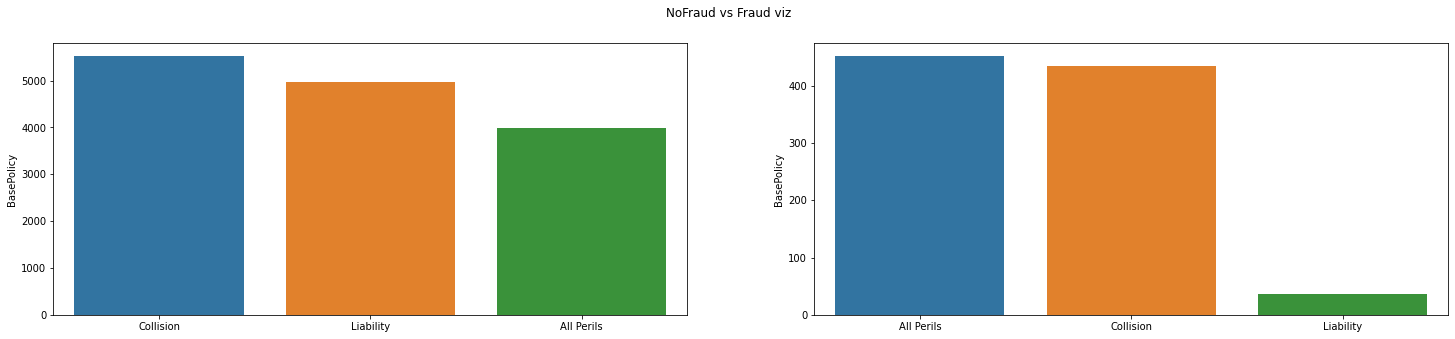

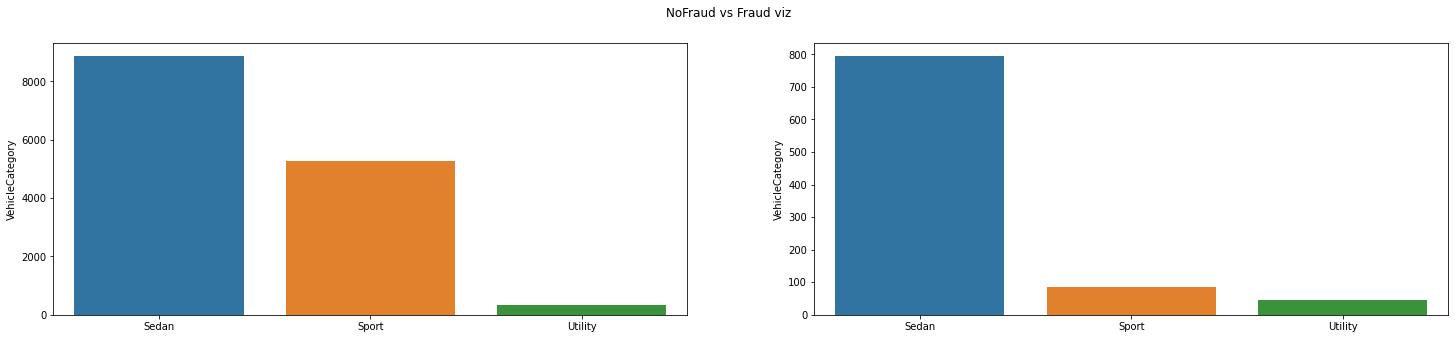

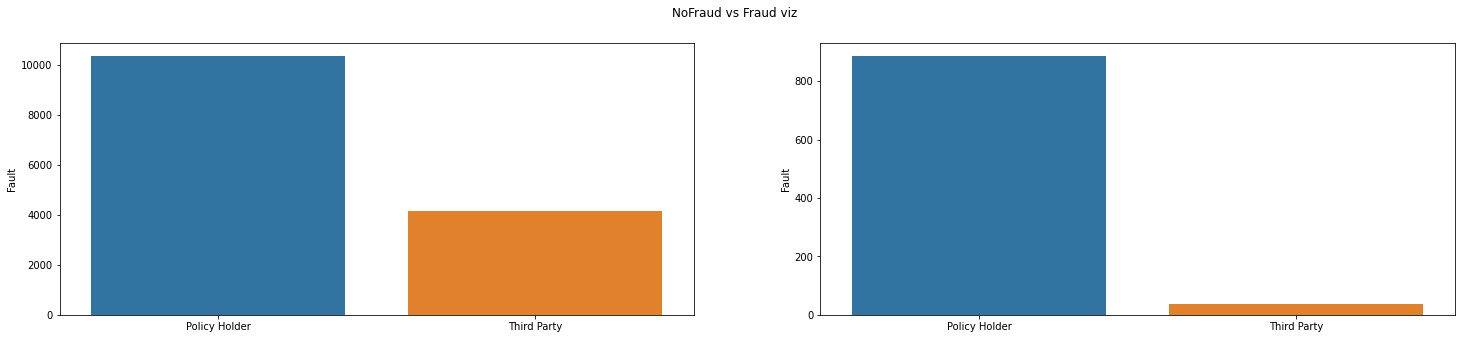

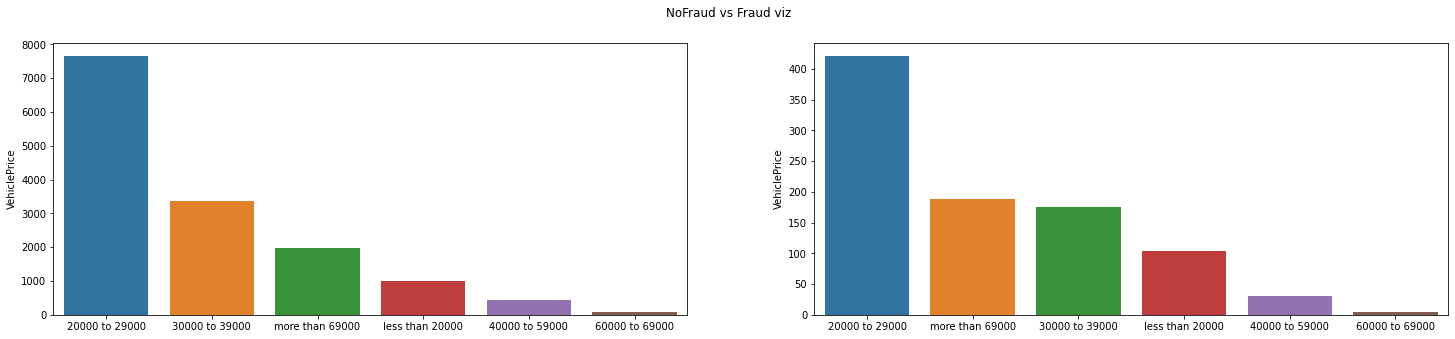

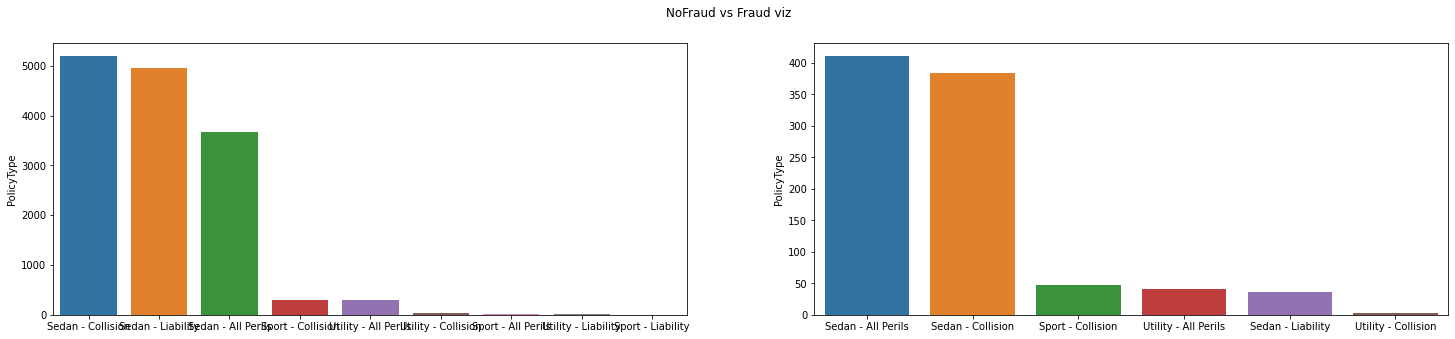

In [7]:
#creating two different lists for highly-correlated variables and low-correlated variables
hi_corr_var=['BasePolicy','VehicleCategory','Fault','VehiclePrice','PolicyType']
lo_corr_var=['DayOfWeekClaimed','MaritalStatus','Month','WeekOfMonth','MonthClaimed','WeekOfMonthClaimed','VehicleCategory','DriverRating','Days_Policy_Accident','WitnessPresent','NumberOfSuppliments','NumberOfCars']

#creating a function to make comparative bar charts
def get_viz(column):
    fig,(ax1, ax2)=plt.pyplot.subplots(1,2,figsize=(25,5))
    fig.suptitle('NoFraud vs Fraud viz')
    sns.barplot(x=nofraud_data[column].value_counts().index,y=nofraud_data[column].value_counts(),ax=ax1)
    sns.barplot(x=fraud_data[column].value_counts().index,y=fraud_data[column].value_counts(),ax=ax2)
    
#creating another function to run the above function on every variable at once
def multi_viz(list):
    mv_list=[]
    for x in list:
        if x not in mv_list:
            get_viz(x)
multi_viz(hi_corr_var)

**Step 3: Fraud Detection with RandomForestRegressor model**

Based on our analysis, feature selection may be a key factor in our machine learning model. Let's create a simple RandomForestRegressor model and see how it performs. To do this, we'll need a balanced dataset. That means we have the same number of fraudulent subjects as non-fraudulent ones. Let's create a balanced dataset now.

In [8]:
#creating a balanced dataset
red_nof_data=nofraud_data.sample(n=923,replace=True,random_state=1)
model_data=pd.concat([red_nof_data,fraud_data])
model_data.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,Deductible,DriverRating,Year
count,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000
mean,2.774106,2.719393,39.354280,0.500000,409.588299,2.517876,1994.826652
std,1.275324,1.262905,13.637433,0.500135,46.447144,1.127366,0.799230
min,1.000000,1.000000,0.000000,0.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,30.000000,0.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.500000,400.000000,3.000000,1995.000000
75%,4.000000,4.000000,48.000000,1.000000,400.000000,4.000000,1995.000000
max,5.000000,5.000000,80.000000,1.000000,700.000000,4.000000,1996.000000


Now, we'll tranform all the string data to integer data, then create a RandomForestRegressor algorithm. We'll create a simple train-test-split, then use the basic model without any hyperparameter tuning.

In [9]:
#transforming string to integer data again
def transform(column):
    label=LabelEncoder().fit_transform(model_data[column])
    model_data.drop(column,axis=1,inplace=True)
    model_data[column]=label
def multi_transform(list):
    mt_list=[]
    for x in list:
        if x not in mt_list:
            transform(x)
multi_transform(attributes)

#building the model
y=model_data.FraudFound_P
X=model_data[attributes]

train_X,test_X,train_y,test_y=train_test_split(X,y,random_state=0)

model = RandomForestRegressor(random_state=1)
model.fit(train_X, train_y)
predictions=model.predict(test_X)

#checking accuracy
print('MAE:',mean_absolute_error(test_y,predictions))
print('Max Error:',max_error(test_y,predictions))

MAE: 0.3028787878787879
Max Error: 0.95


Here's our baseline results. We're using Mean Absolute Error alongside Max Error to determine how well our model is doing. The goal is to make a confident statement about which claims should be investigated further, and which are probably not fraudulent.

If we wanted to say "any claim with a predicted score of .5 or higher is most-likely fraudulent", we would want the Max Error to be less than .5, and the Mean Absolute Error to be around .25, but it looks like our Max Error is waaay off.

Let's try to implement feature selection, and see what effect that has on the model.

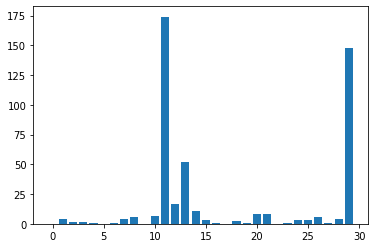

In [10]:
#checking correlation for feature selection
fs=SelectKBest(score_func=f_regression, k='all')
fs.fit(train_X, train_y)
train_X_fs=fs.transform(train_X)
test_X_fs=fs.transform(test_X)

#plotting correlation
pyplot.bar([i for i in range(len(fs.scores_))],fs.scores_)
pyplot.show()

Now we can apply these results to the RandomForestRegressor model and see how it affects the results.

In [11]:
#feature selection
def select_features(train_X,train_y,test_X):
    fr = SelectKBest(score_func=f_regression,k=4)
    fr.fit(train_X,train_y)
    train_X_fr=fr.transform(train_X)
    test_X_fr=fr.transform(test_X)
    return train_X_fr,test_X_fr,fr
train_X_fr,test_X_fr,fr=select_features(train_X,train_y,test_X)

#fitting the model with feature selection
model=RandomForestRegressor(random_state=1)
model.fit(train_X_fr,train_y)
predictions2=model.predict(test_X_fr)

#checking accuracy
print('MAE:',mean_absolute_error(test_y,predictions2))
print('Max Error:',max_error(test_y,predictions2))

MAE: 0.34619500782894796
Max Error: 0.9043638381907092


Well, it looks like feature selection had a small effect on the Max Error, but also made the Mean Absolute Error even worse. It's possible that we overdid it, and left the model without enough information.

Let's take away the feature selection, and try to improve our first model with some hyperparameter tuning.

In [12]:
model = RandomForestRegressor(random_state=1,n_estimators=200,max_depth=10,min_samples_split=3,max_leaf_nodes=2,max_samples=20)
model.fit(train_X, train_y)
predictions=model.predict(test_X)

#checking accuracy
print('MAE:',mean_absolute_error(test_y,predictions))
print('Max Error:',max_error(test_y,predictions))

MAE: 0.4714715760871701
Max Error: 0.6026276419658774


Wow! Just some simple hyperparameter tuning has brought our Max Error down from .95 to .60! Unfortunately, the Mean Absolute Error also went up by a pretty significant amount. That means that, although the highest errors have been brought down, our average error is higher.

Let's try combining our hyperparameter tuning and the feature selection from earlier.

In [13]:
model=RandomForestRegressor(random_state=1,n_estimators=200,max_depth=10,min_samples_split=3,max_leaf_nodes=2,max_samples=20)
model.fit(train_X_fr,train_y)
predictions2=model.predict(test_X_fr)

print('MAE:',mean_absolute_error(test_y,predictions2))
print('Max Error:',max_error(test_y,predictions2))

MAE: 0.42535281310851003
Max Error: 0.6884586476689805


Not bad! We brought down the Mean Absolute Error, and the Max Error is still at a reasonable level.

We've created a model for predicting fraud, and systematically improved it using hyperparameter tuning and feature selection. We can confidently say that the largest error our model created was .69, and its average error is .43.

In the future, training the model on larger datasets and continuing to tweak its hyperparameters could lead to even more impressive results.